<a href="https://colab.research.google.com/github/Mark42Zhong/Just-for-fun/blob/main/%E6%9C%AC%E7%A7%91_%E9%92%9F%E9%B8%BF%E6%96%8C_2018053287_%E5%8F%8C%E8%BE%B9%E6%BB%A4%E6%B3%A2%E5%AE%9E%E9%AA%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

样本图片src_img：


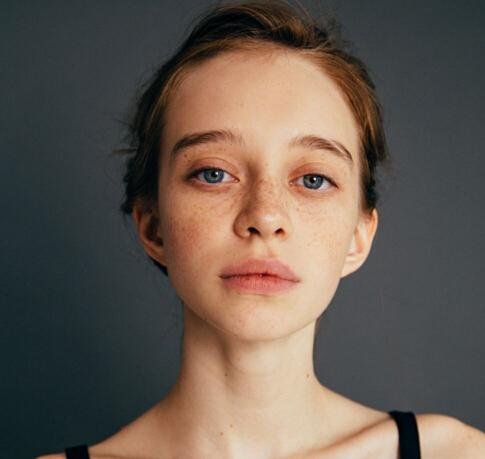

In [1]:
import cv2
import os
import numpy as np
from urllib.request import Request, urlopen
from google.colab.patches import cv2_imshow
%matplotlib inline

"""
  样本文件夹的创建
  and
  样本图片src_img的导入
"""
def mkdir(path):
  isExist = os.path.exists(path)
  if not isExist:
    os.makedirs(path)
    return True
  else:
    return False

def url_to_img(url):
  hdr = {'User-Agent':'Mozilla/5.0'}
  req = Request(url, headers=hdr)
  response = urlopen(req)
  img_array = np.array(bytearray(response.read()), dtype=np.uint8)
  img = cv2.imdecode(img_array, -1)
  return img

if __name__ == "__main__":
  path = "/tmp/test_img/"
  url = "https://i1.kknews.cc/SIG=28k4ihu/o0r0001rr2418r2rqn4.jpg"
  mkdir(path)
  src_img = url_to_img(url)
  cv2.imwrite("/tmp/test_img/src_img.jpg", src_img)
  print("样本图片src_img：")
  cv2_imshow(src_img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: overflow encountered in ubyte_scalars


1.src_img  2.RGB  3.HSV
4.HLS  5.LAB 6.YUV


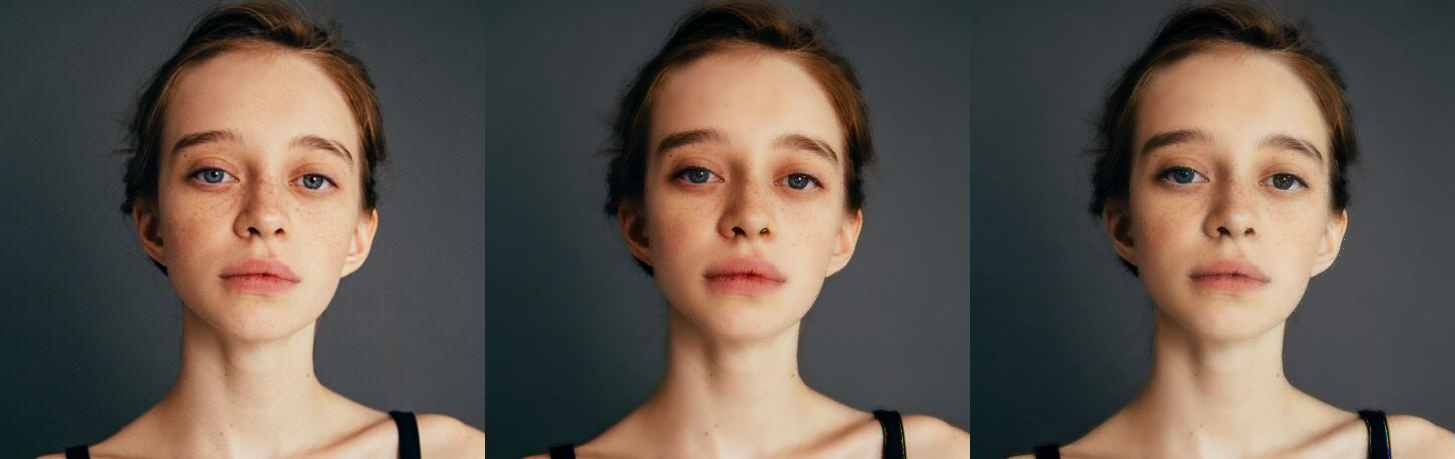

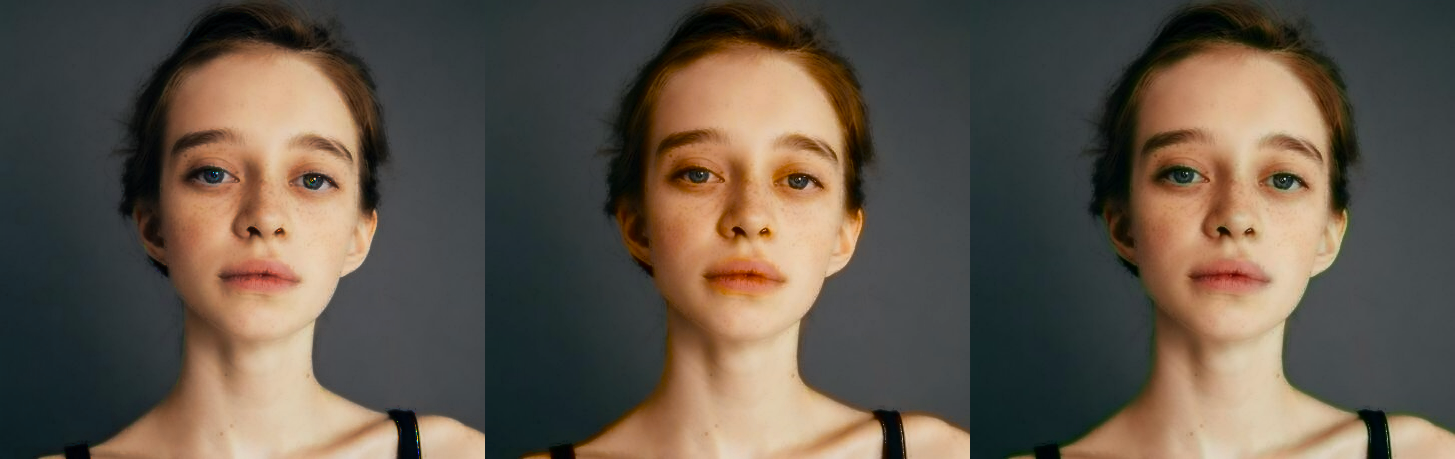

In [4]:
#双边滤波器bilateral filter
import numpy as np
import cv2
import math
import os
from google.colab.patches import cv2_imshow


def spatial_distance_square(diameter, sigma_d):
  """
  计算距离高斯函数的模板函数
  :param
    diameter: 高斯核直径
    sigma_d: 坐标空间的sigma参数，该参数较大时，只要颜色相近，越远的像素会相互影响
  :return: 
    已经计算好的距离高斯函数值字典
  """
  d_weight = {}
  coefficient = -0.5 / (sigma_d ** 2)
  x, y = diameter // 2, diameter // 2
  for k in range(x+1):
    for l in range(y+1):
      distance = (k-x)**2 + (l-y)**2
      if distance not in d_weight:
        d_weight[distance] = math.exp(distance * coefficient)
  return d_weight
  

def pixel_difference_square(sigma_r):
  """
  计算相似度高斯函数的模板函数
  :param
    sigma_r: 色彩空间的sigma参数，该参数较大时，各像素邻域内相距较远的颜色会被混合到一起，从而造成更大范围的半相等颜色
  :return: 
    已经计算好的相似度高斯函数值字典
  """
  r_weight = {}
  coefficient = -0.5 / (sigma_r ** 2)
  for i in range(256):
    r_weight[i] = math.exp(i * i * coefficient)
  return r_weight


def bilateral_filter_func(img, diameter, sigma_d, sigma_r):
  """
  双边滤波器函数
  :param
    img: 样本照片
    diameter: 高斯核直径
    sigma_d: 坐标空间的sigma参数，该参数较大时，只要颜色相近，越远的像素会相互影响
    sigma_r: 色彩空间的sigma参数，该参数较大时，各像素邻域内相距较远的颜色会被混合到一起，从而造成更大范围的半相等颜色
  :return: 
    双边滤波后的图片
  """
  new_image = np.zeros(img.shape)
  #提前计算好距离模板和相似度模板
  d_weight = spatial_distance_square(diameter, sigma_d)
  r_weight = pixel_difference_square(sigma_r) 

  for row in range(img.shape[0]):
    for col in range(img.shape[1]):
      w_sum = 0
      filter_img = 0
      for k in range(diameter):
        for l in range(diameter):
          n_x =row - ((diameter+1)/2 - k - 1)
          n_y =col - ((diameter+1)/2 - l - 1)
          n_x, n_y = int(n_x), int(n_y)
          #zero padding
          if n_x < 0 or n_x >= img.shape[0] or n_y < 0 or n_y >= img.shape[1]:
            w_sum += 0
            filter_img += 0
            continue
          
          #查询距离模板和相似度模板求出权值w
          distance = (row-n_x)**2 + (col-n_y)**2
          pixel_difference = img[row][col] - img[n_x][n_y]
          w = d_weight[distance] * r_weight[pixel_difference] 
          w_sum += w
          filter_img = filter_img + img[n_x][n_y] * w
      new_image[row][col] = math.floor(filter_img / w_sum)
  return new_image

def main():
  '''
  探究彩色图片在RGB、HSV、HLS、LAB、YUV色彩空间上的双边滤波器的表现效果。
  '''
  src_img = cv2.imread(r"/tmp/test_img/src_img.jpg")
  difference_color_space_imgs = {}
  result_imgs = {}

  #RGB空间
  RGB_img = src_img
  difference_color_space_imgs['RGB'] = src_img
  #HSV空间
  HSV_img = cv2.cvtColor(src_img, cv2.COLOR_RGB2HSV)
  difference_color_space_imgs['HSV'] = HSV_img
  #HLS空间
  HLS_img = cv2.cvtColor(src_img, cv2.COLOR_RGB2HLS)
  difference_color_space_imgs['HLS'] = HLS_img
  #LAB空间
  LAB_img = cv2.cvtColor(src_img, cv2.COLOR_RGB2LAB)
  difference_color_space_imgs['LAB'] = LAB_img
  #YUV空间
  YUV_img = cv2.cvtColor(src_img, cv2.COLOR_RGB2YUV)
  difference_color_space_imgs['YUV'] = YUV_img

  #超参数
  diameter, sigma_d, sigma_r = 11, 40, 40

  # for space_name, img in difference_color_space_imgs.items():
  #   print(space_name)
  #   cv2_imshow(img)
  #   print(img.shape)

  """
    将彩色图片分成三通道进行双边滤波，再进行合成保存
  """
  for space_name, img in difference_color_space_imgs.items():
    s1, s2, s3 = cv2.split(img)
    imgs = [s1, s2, s3]

    dst_imgs = []
    for img in imgs:
      dst_img = bilateral_filter_func(img, diameter, sigma_d, sigma_r)
      dst_imgs.append(dst_img)
    dst_img = cv2.merge(dst_imgs)
    difference_color_space_imgs[space_name] = dst_img
  
  #RGB空间
  result_imgs['RGB'] = difference_color_space_imgs['RGB']
  #HSV空间
  result_imgs['HSV'] = cv2.cvtColor(difference_color_space_imgs['HSV'].astype('uint8'), cv2.COLOR_HSV2RGB)
  #HLS空间
  result_imgs['HLS'] = cv2.cvtColor(difference_color_space_imgs['HLS'].astype('uint8'), cv2.COLOR_HLS2RGB)
  #LAB空间
  result_imgs['LAB'] = cv2.cvtColor(difference_color_space_imgs['LAB'].astype('uint8'), cv2.COLOR_LAB2RGB)
  #YUV空间
  result_imgs['YUV'] = cv2.cvtColor(difference_color_space_imgs['YUV'].astype('uint8'), cv2.COLOR_YUV2RGB)

  for space_name, img in result_imgs.items():
    cv2.imwrite(r"/tmp/test_img/11-40-40{0}.jpg".format(space_name), img)

  imgs1 = np.hstack([src_img, result_imgs['RGB'], result_imgs['HSV']])
  imgs2 = np.hstack([result_imgs['HLS'], result_imgs['LAB'], result_imgs['YUV']])
  print("1.src_img  2.RGB  3.HSV")
  print("4.HLS  5.LAB 6.YUV")
  cv2_imshow(imgs1)
  cv2_imshow(imgs2)

if __name__ == "__main__":

  main()